<a href="https://colab.research.google.com/github/RShoose/Data/blob/main/object_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ultralytics

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import tensorflow
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GroupNormalization, Dense, Activation, Input, SpatialDropout2D, GlobalAveragePooling2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Prepare Data**

**Data collection block.**

*In this block data collection from train,valid and test data image*

In [ ]:
path_to_dir_data_train_images = Path('/kaggle/input/cardetection/train/images')
path_to_dir_data_train_labels = Path('/kaggle/input/cardetection/train/labels')
dict_train_data = {'images':[],
                   'labels':[]
                  }
for i in os.listdir(path_to_dir_data_train_images):
    path_to_train_images = Path(path_to_dir_data_train_images,i)
    path_to_train_labels = Path(path_to_dir_data_train_labels,i[:-4]+'.txt')
    with open(path_to_train_labels,'r') as f:
        for i in f.readlines():
            i = re.sub(r'\n','',i)
            dict_train_data['images'].append(str(path_to_train_images))
            dict_train_data['labels'].append(i)


df_train = pd.DataFrame(dict_train_data)


In [ ]:
path_to_dir_data_valid_images = Path('/kaggle/input/cardetection/valid/images')
path_to_dir_data_valid_labels = Path('/kaggle/input/cardetection/valid/labels')
dict_valid_data = {'images':[],
                   'labels':[]
                  }
for i in os.listdir(path_to_dir_data_valid_images):
    path_to_valid_images = Path(path_to_dir_data_valid_images,i)
    path_to_valid_labels = Path(path_to_dir_data_valid_labels,i[:-4]+'.txt')
    with open(path_to_valid_labels,'r') as f:
        for i in f.readlines():
            i = re.sub(r'\n','',i)
            dict_valid_data['images'].append(str(path_to_valid_images))
            dict_valid_data['labels'].append(i)

df_valid = pd.DataFrame(dict_valid_data)

In [ ]:
path_to_dir_data_test_images = Path('/kaggle/input/cardetection/test/images')
path_to_dir_data_test_labels = Path('/kaggle/input/cardetection/test/labels')
dict_test_data = {'images':[],
                   'labels':[]
                 }
for i in os.listdir(path_to_dir_data_test_images):
    path_to_test_images = Path(path_to_dir_data_test_images,i)
    path_to_test_labels = Path(path_to_dir_data_test_labels,i[:-4]+'.txt')
    with open(path_to_test_labels,'r') as f:
        for i in f.readlines():
            i = re.sub(r'\n','',i)
            dict_test_data['images'].append(str(path_to_test_images))
            dict_test_data['labels'].append(i)

df_test = pd.DataFrame(dict_test_data)

**Melt labels**

In [ ]:
def process_labels(labels_str):
    labels_list = labels_str.split()
    class_id = int(labels_list[0])
    x_min, y_min, x_max, y_max = map(np.float32, labels_list[1:])
    return class_id, x_min, y_min, x_max, y_max

In [ ]:
df_train['labels'] = df_train['labels'].apply(process_labels)
df_valid['labels'] = df_valid['labels'].apply(process_labels)
df_test['labels'] = df_test['labels'].apply(process_labels)


df_train[['class_id', 'x_min', 'y_min', 'x_max', 'y_max']] = pd.DataFrame(df_train['labels'].tolist(), index=df_train.index)
df_train = df_train.drop('labels', axis=1)
df_valid[['class_id', 'x_min', 'y_min', 'x_max', 'y_max']] = pd.DataFrame(df_valid['labels'].tolist(), index=df_valid.index)
df_valid = df_valid.drop('labels', axis=1)
df_test[['class_id', 'x_min', 'y_min', 'x_max', 'y_max']] = pd.DataFrame(df_test['labels'].tolist(), index=df_test.index)
df_test = df_test.drop('labels', axis=1)

**Datageneration by ImageDataGenerator**

Input data:
df, where contained paths to images and labels.

Output data:
tuple images and labels in the form array

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='images',
    y_col=['class_id', 'x_min', 'y_min', 'x_max', 'y_max'],
    target_size=(416, 416),
    batch_size=64,
    class_mode='other',
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='images',
    y_col=['class_id', 'x_min', 'y_min', 'x_max', 'y_max'],
    target_size=(416, 416),
    class_mode='other'
)

# Model

In [ ]:
# function resnet blocks
def residual_block_layer(x, filters=32,
                         kernel_size=3,
                         strides=1,
                         activation='elu',
                         type_regularization = 'normalization', #dropout
                         rate_dropout=0.1,
                         conv_first=False):

    conv_layer = Conv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding="same",
                        kernel_initializer='he_normal')
    if conv_first:# if first convolution layers
        x = conv_layer(x)
        if type_regularization == 'normalization':
            x = GroupNormalization()(x)
        elif type_regularization == 'dropout':
            x = SpatialDropout2D(rate=rate_dropout)(x)
    else:# if non first convolution layers
        if type_regularization == 'normalization':
            x = GroupNormalization()(x)
        elif type_regularization == 'dropout':
            x = SpatialDropout2D(rate=rate_dropout)(x)
        x = conv_layer(x)

    return x

In [ ]:
# neural network architecture
def cnn(input_shape, count_classes, count_boxes):
    inputs = Input(shape=input_shape)

    strides = 1
    # check number strides counts
    if strides != 1:
        x = residual_block_layer(inputs, strides=strides,conv_first=True)
        x = residual_block_layer(x, activation='elu')
    else:
        x = residual_block_layer(inputs, conv_first=True)
    # loop for get features map
    for filters in [64,128,256]:
        y = SeparableConv2D(filters, 3, padding="same")(x)
        y = GroupNormalization()(y)
        y = Activation("elu")(y)
        y = MaxPooling2D(3, strides=2, padding="same")(y)

        x = residual_block_layer(y,filters=filters)

        y = tensorflow.keras.layers.Add()([y, x])

        y = SeparableConv2D(filters, 3, padding="same")(y)
        y = GroupNormalization()(y)
        y = Activation("elu")(y)
        y = MaxPooling2D(3, strides=2, padding="same")(y)

        x = residual_block_layer(y,filters=filters,type_regularization='dropout',rate_dropout=0.3)

        y = tensorflow.keras.layers.Add()([y, x])

    y = GlobalAveragePooling2D()(y)


    y = Dense(512, activation='elu')(y)
    # layer for classification object
    classification_output = Dense(count_classes, activation='softmax',name='classification')(y)
    # layer for Bounding Box regression
    regression_output = Dense(4 * count_boxes, activation='linear',name='regression')(y)
    model = tensorflow.keras.Model(inputs=inputs, outputs=[classification_output, regression_output])

    return model

In [ ]:
input_shape = (416,416,3)
count_classes = 1
count_boxes = 1

model = cnn(input_shape,count_classes,count_boxes)
model.summary()

In [ ]:
model.compile(optimizer=AdamW(),
              loss={'classification': 'categorical_crossentropy', 'regression': 'mean_squared_error'},
              metrics={'classification': 'accuracy', 'regression': 'mae'})

In [ ]:
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epoch_drop = 15
    lr = initial_lr * (drop ** (epoch // epoch_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
model.fit(train_generator,
          epochs=50, callbacks=[lr_scheduler],
          validation_data=validation_generator)

K.clear_session()

# YOLO Model

***Description YOLO AI***

YOLOv8 is the latest version of the YOLO AI model developed by Ultralytics, which has shown effectiveness in tackling tasks such as classification, object detection, and image segmentation. YOLOv8 models are fast, accurate, and easy to use, making them ideal for various object detection and image segmentation tasks. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs. YOLOv8 detection models have no suffix and are the default YOLOv8 models, i.e. yolov8n.pt ,and are pre-trained on COCO. See Detection Docs for full details.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

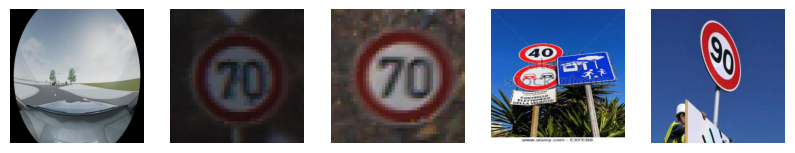

In [ ]:
images_path = '/kaggle/input/cardetection/train/images/'
image_files = os.listdir(images_path)

fig, ax = plt.subplots(1, 5, figsize=(10, 10))

for i in range(5):
    ax[i].imshow(Image.open(images_path+image_files[i+10]), cmap='gray')
    ax[i].axis('off')

In [ ]:
image = Image.open('/kaggle/input/cardetection/train/images/00000_00000_00002_png.rf.c8ad86390583e313b909403180f01ffd.jpg')
print(f'Image size: {image.size}')
print(f'Image chanels: {image.mode}')

Image size: (416, 416)
Image chanels: RGB


100%|██████████| 6.23M/6.23M [00:00<00:00, 152MB/s]



image 1/1 /kaggle/input/cardetection/train/images/000820_jpg.rf.12a2946a7043d85489ad3344162592a0.jpg: 416x416 1 car, 1 bus, 1 truck, 1 stop sign, 6.5ms
Speed: 6.3ms preprocess, 6.5ms inference, 196.5ms postprocess per image at shape (1, 3, 416, 416)


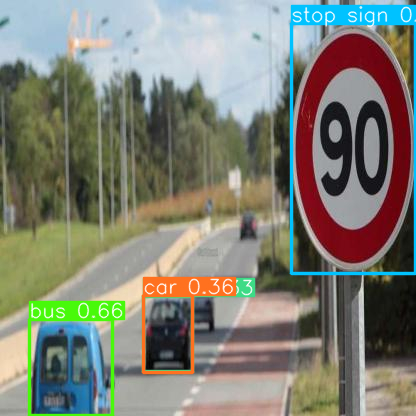

In [ ]:
model = YOLO('yolov8n.pt')

pred = model.predict(source='/kaggle/input/cardetection/train/images/000820_jpg.rf.12a2946a7043d85489ad3344162592a0.jpg',imgsz=(416))
plot = pred[0].plot()
display(Image.fromarray(plot[...,::-1]))

In [ ]:
model_train= YOLO('yolov8n.yaml').load('yolov8n.pt')

model_train.train(data='/kaggle/input/cardetection/data.yaml', epochs=50,imgsz=416,batch=64,device=0,optimizer='AdamW',dropout=0.2,plots=True)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/input/cardetection/data.yaml, epochs=50, time=None, patience=50, batch=64, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf

100%|██████████| 755k/755k [00:00<00:00, 35.8MB/s]
2024-01-22 13:41:45,278	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-22 13:41:45,710	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/input/cardetection/train/labels... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:27<00:00, 127.24it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/cardetection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/cardetection/valid/labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:04<00:00, 168.80it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/cardetection/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.49G      1.029      2.855      1.161         27        416: 100%|██████████| 56/56 [00:21<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


                   all        801        944      0.148     0.0938    0.00332    0.00106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.57G      1.004      2.117      1.123         22        416: 100%|██████████| 56/56 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


                   all        801        944        0.1      0.114     0.0116    0.00595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.57G     0.9949      2.022      1.112         25        416: 100%|██████████| 56/56 [00:17<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


                   all        801        944     0.0218     0.0987     0.0117    0.00731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.57G     0.9629      1.961      1.108         20        416: 100%|██████████| 56/56 [00:17<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


                   all        801        944      0.874     0.0792     0.0941     0.0616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.57G     0.8733      1.851      1.057         25        416: 100%|██████████| 56/56 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


                   all        801        944      0.127      0.229      0.163      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.56G     0.8415      1.803      1.043         34        416: 100%|██████████| 56/56 [00:18<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        801        944       0.13      0.438      0.199      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.56G     0.7974      1.728      1.022         23        416: 100%|██████████| 56/56 [00:18<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        801        944      0.171        0.4      0.233      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.57G     0.7921      1.688      1.022         23        416: 100%|██████████| 56/56 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


                   all        801        944      0.142      0.358      0.214      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.57G     0.7718       1.66      1.014         20        416: 100%|██████████| 56/56 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        801        944      0.202      0.475      0.253      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.56G     0.7565      1.624      1.001         20        416: 100%|██████████| 56/56 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        801        944      0.239      0.502      0.321      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.56G     0.7395      1.601     0.9969         20        416: 100%|██████████| 56/56 [00:17<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        801        944      0.263      0.537      0.355      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.56G     0.7277      1.567     0.9897         21        416: 100%|██████████| 56/56 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        801        944      0.276      0.344      0.329      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.56G     0.7313      1.541       0.99         35        416: 100%|██████████| 56/56 [00:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        801        944       0.39      0.451      0.345      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.56G      0.702      1.494      0.981         25        416: 100%|██████████| 56/56 [00:17<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        801        944      0.284      0.434      0.339      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.56G     0.6913      1.475     0.9774         19        416: 100%|██████████| 56/56 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        801        944      0.368      0.512      0.383      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.56G     0.6854      1.449      0.974         22        416: 100%|██████████| 56/56 [00:18<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        801        944      0.318      0.559      0.408      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.56G     0.6872       1.43     0.9779         22        416: 100%|██████████| 56/56 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        801        944      0.416       0.49      0.424      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.56G     0.6758      1.396     0.9677         20        416: 100%|██████████| 56/56 [00:20<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        801        944      0.353       0.52      0.385       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.56G     0.6678      1.345     0.9697         23        416: 100%|██████████| 56/56 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        801        944      0.401      0.601      0.447      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.56G     0.6715      1.315     0.9689         23        416: 100%|██████████| 56/56 [00:17<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        801        944       0.49      0.555      0.548      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.56G      0.688      1.275     0.9712         27        416: 100%|██████████| 56/56 [00:17<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        801        944       0.52      0.626      0.562      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.56G     0.6487      1.216     0.9623         17        416: 100%|██████████| 56/56 [00:17<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        801        944      0.634      0.614      0.612      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.56G     0.6534      1.195     0.9648         24        416: 100%|██████████| 56/56 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        801        944      0.593      0.666      0.652      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.56G      0.645      1.135     0.9545         25        416: 100%|██████████| 56/56 [00:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        801        944      0.579       0.57      0.581      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.56G     0.6396      1.087     0.9548         33        416: 100%|██████████| 56/56 [00:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        801        944      0.716      0.654      0.706      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.56G     0.6308      1.047     0.9489         25        416: 100%|██████████| 56/56 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        801        944      0.719      0.686      0.744      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.56G     0.6214      1.034     0.9518         21        416: 100%|██████████| 56/56 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        801        944      0.736      0.697      0.766      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.56G     0.6357      0.986     0.9523         23        416: 100%|██████████| 56/56 [00:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        801        944      0.761       0.71      0.768      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.56G     0.6253     0.9783     0.9461         25        416: 100%|██████████| 56/56 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        801        944      0.778      0.741      0.804      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.56G     0.6126     0.9421     0.9471         14        416: 100%|██████████| 56/56 [00:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        801        944      0.875      0.735      0.819      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.56G     0.6112     0.9275     0.9461         19        416: 100%|██████████| 56/56 [00:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        801        944      0.808      0.748      0.814      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.56G     0.5994     0.8954      0.942         20        416: 100%|██████████| 56/56 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        801        944       0.85      0.775      0.843      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.56G     0.6037     0.8854      0.941         23        416: 100%|██████████| 56/56 [00:18<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        801        944      0.858      0.764      0.841      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.56G     0.6052     0.8588     0.9411         18        416: 100%|██████████| 56/56 [00:18<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        801        944      0.874      0.777      0.855      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.56G     0.5872     0.8433     0.9392         23        416: 100%|██████████| 56/56 [00:18<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        801        944       0.89      0.777      0.854      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.56G     0.5873     0.8353     0.9337         24        416: 100%|██████████| 56/56 [00:18<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        801        944      0.891      0.781      0.863      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.56G      0.575     0.8102     0.9337         12        416: 100%|██████████| 56/56 [00:18<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        801        944      0.838      0.772      0.836       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.56G     0.5876     0.8044     0.9332         24        416: 100%|██████████| 56/56 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        801        944      0.886      0.782      0.856      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.56G     0.5705     0.7722     0.9269         13        416: 100%|██████████| 56/56 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        801        944      0.909       0.77      0.867       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.56G     0.5668     0.7836     0.9319         12        416: 100%|██████████| 56/56 [00:18<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        801        944        0.9      0.792      0.874      0.755


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.56G       0.56     0.5358     0.8891         13        416: 100%|██████████| 56/56 [00:19<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        801        944      0.935      0.776      0.869      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.56G     0.5582     0.5138     0.8853         14        416: 100%|██████████| 56/56 [00:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        801        944      0.922      0.785      0.874      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.56G      0.547     0.5119     0.8844         11        416: 100%|██████████| 56/56 [00:16<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        801        944      0.929      0.807      0.885      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.56G     0.5433     0.4855     0.8835         10        416: 100%|██████████| 56/56 [00:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        801        944      0.946      0.796      0.884      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.56G     0.5255     0.4644     0.8776         12        416: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        801        944      0.937      0.799      0.888      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.56G     0.5223     0.4412     0.8785         10        416: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        801        944      0.921      0.817      0.893      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.56G     0.5193     0.4268     0.8723         13        416: 100%|██████████| 56/56 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        801        944      0.938      0.816      0.894      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.56G     0.5169     0.4171     0.8727         14        416: 100%|██████████| 56/56 [00:16<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        801        944      0.926      0.824      0.894      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.56G     0.5068     0.4119     0.8668         14        416: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        801        944      0.948      0.815      0.896      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.56G     0.5016     0.3975     0.8698         13        416: 100%|██████████| 56/56 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        801        944      0.934      0.827      0.898      0.783



50 epochs completed in 0.316 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.4 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv8n summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


                   all        801        944      0.948      0.815      0.896      0.783
           Green Light        801        122      0.938      0.541      0.677      0.404
             Red Light        801        108      0.834      0.537       0.65      0.395
       Speed Limit 100        801         52      0.947      0.904      0.959      0.871
       Speed Limit 110        801         17      0.945      0.824      0.927      0.846
       Speed Limit 120        801         60      0.969      0.883      0.964      0.877
        Speed Limit 20        801         56          1      0.904      0.977      0.841
        Speed Limit 30        801         74      0.958      0.905      0.954      0.892
        Speed Limit 40        801         55      0.923      0.873      0.953      0.862
        Speed Limit 50        801         71      0.965       0.77      0.913       0.83
        Speed Limit 60        801         76       0.99      0.882      0.929      0.845
        Speed Limit 7

lr/pg0,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▃▆████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▁▂▃▃▃▃▄▄▄▄▄▄▄▄▅▆▆▆▇▇▇▇▇███████████████
metrics/mAP50-95(B),▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▆▆▅▇▇▇▇▇▇███▇██████████
metrics/precision(B),▂▂▁▇▂▂▂▂▃▃▄▃▃▄▄▄▅▆▅▅▆▆▇▇▇▇▇▇█▇██████████
metrics/recall(B),▁▁▁▁▄▄▄▅▅▃▄▄▆▅▅▆▆▆▇▆▇▇▇▇▇█▇████▇████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,███▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f88241f3250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0


image 1/1 /kaggle/input/cardetection/train/images/000820_jpg.rf.12a2946a7043d85489ad3344162592a0.jpg: 416x416 1 Speed Limit 90, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


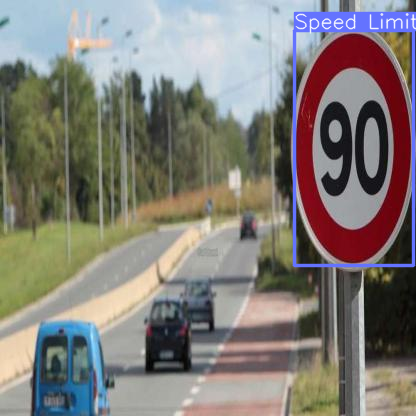

In [ ]:
pred = model_train.predict(source='/kaggle/input/cardetection/train/images/000820_jpg.rf.12a2946a7043d85489ad3344162592a0.jpg',imgsz=(416))
plot = pred[0].plot()
display(Image.fromarray(plot[...,::-1]))

<p>Для опиcания и анализа я взял модель YOLO.</p>
<p align='justify'>Архитектура данной модели представляет имплементацию Darknet со своими доработками для улучшения производительности. Также для задачи детекции обьевтов используется последний слой полносвязный для предсказывания границ и размеров маски и предсказания класса объекта в маске.</p>

Ниже представлен рисунок архитектуры YOLOV3:
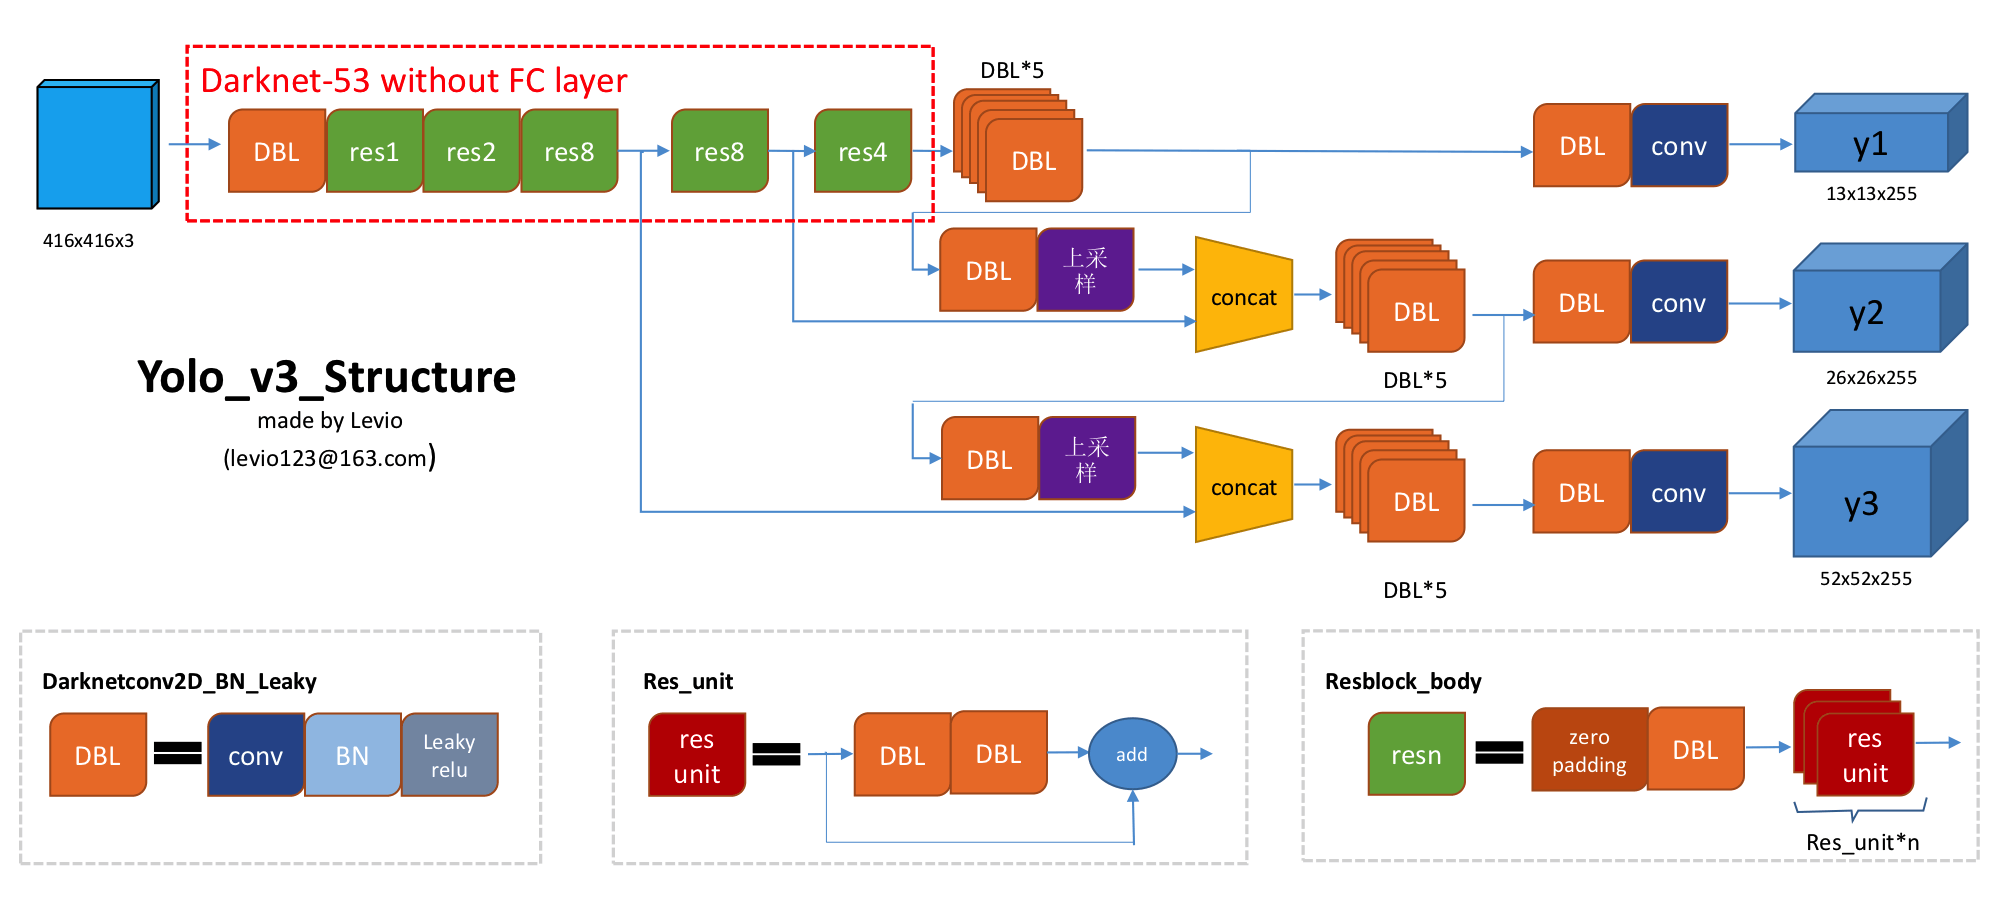

<h3>YOLO: Краткая история</h3>
<p>YOLO (You Only Look Once), популярная модель обнаружения объектов и сегментации изображений, была разработана Джозефом Редмоном и Али Фархади в Университете Вашингтона. Появившись в 2015 году, YOLO быстро завоевала популярность благодаря своей высокой скорости и точности.</p>
<ul>
    <li>YOLOv2, выпущенный в 2016 году, улучшил исходную модель, включив пакетную нормализацию, блоки привязок и кластеры измерений.</li>
    <li>YOLOv3, запущенный в 2018 году, еще больше повысил производительность модели, используя более эффективную магистральную сеть, множество привязок и объединение пространственных пирамид.</li>
    <li>YOLOv4 был выпущен в 2020 году, в нем были представлены такие инновации, как Mosaic data augmentation, новый anchor free detection head и новая функция потери данных.</li>
    <li>YOLOv5 еще больше повысил производительность модели и добавил новые возможности, такие как оптимизация гиперпараметров, интегрированное отслеживание экспериментов и автоматический экспорт в популярные форматы.</li>
    <li>YOLOv6 был открыт компанией Meituan в 2022 году и используется во многих автономных роботах-доставщиках компании.</li>
    <li>В YOLOv7 добавлены дополнительные задачи, такие как оценка позы по набору данных COCO keypoints.</li>
    <li>YOLOv8 Это последняя версия YOLO от Ultralytics. Являясь передовой, современной (SOTA) моделью, YOLOv8 опирается на успех предыдущих версий, представляя новые возможности и улучшения для повышения производительности, гибкости и эффективности. YOLOv8 поддерживает полный спектр задач ИИ зрения, включая обнаружение, сегментацию, оценку позы, отслеживание и классификацию. Такая универсальность позволяет пользователям использовать возможности YOLOv8 в различных приложениях и областях.</li>
</ul>

<h3>Преимущества YOLO</h3>
<ul>
    <li>Нет явных циклов «for», из-за чего сеть работает быстро.</li>
    <li>Возможность обработки real-time информации.</li>
    <li>Высокая точность.</li>
    <li>Поддержка фотографий и изображений 640 на 640.</li>
    <li>Предобученные модели обучались на датасете COCO.</li>
</ul>







